<a href="https://colab.research.google.com/github/AsSugar13/ass13_M5/blob/master/new_begining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')
# PATH = './'
PATH = './drive/My Drive/Colab Notebooks/'

# Imports

In [3]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental                       import enable_iterative_imputer
from IPython.display                            import display

from sklearn.linear_model                       import LinearRegression, Ridge, Lasso, HuberRegressor, SGDRegressor
from sklearn.svm                                import SVC, NuSVR, OneClassSVM
from sklearn.pipeline                           import Pipeline, FeatureUnion
from sklearn.preprocessing                      import OrdinalEncoder, FunctionTransformer, OneHotEncoder,\
                                                       KBinsDiscretizer, LabelEncoder, PolynomialFeatures,\
                                                       StandardScaler, MaxAbsScaler, maxabs_scale, OrdinalEncoder
from imblearn.pipeline                          import Pipeline as Pipeline_IMB
from sklearn.impute                             import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.metrics                            import make_scorer, mean_squared_error
from scipy.stats                                import spearmanr
from sklearn.model_selection                    import KFold, StratifiedKFold, GroupKFold, TimeSeriesSplit,\
                                                       RandomizedSearchCV, GridSearchCV
from sklearn.feature_extraction.text            import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.feature_selection                  import SelectKBest, chi2, SelectFromModel, f_regression
from sklearn.decomposition                      import TruncatedSVD

from sklearn.linear_model                       import LogisticRegression
from sklearn.multioutput                        import MultiOutputClassifier, MultiOutputRegressor
from sklearn.multiclass                         import OneVsRestClassifier
from sklearn.ensemble                           import RandomForestClassifier, RandomForestRegressor,\
                                                       AdaBoostRegressor, AdaBoostClassifier, GradientBoostingRegressor
from sklearn.linear_model                       import ElasticNet, BayesianRidge
from sklearn.neural_network                     import MLPRegressor
import xgboost as xgb
from sklearn.model_selection                    import train_test_split, RandomizedSearchCV, GridSearchCV,\
                                                       cross_val_score, cross_val_predict, cross_validate

from imblearn                                   import FunctionSampler
from imblearn.over_sampling                     import SMOTE, SVMSMOTE, ADASYN
from imblearn.combine                           import SMOTETomek

import gc
import re
import pickle
sns.set(style="white", color_codes=True)
%matplotlib inline
%config InlineBackend.figure_format='retina'
np.random.seed(13)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 500)

In [0]:
def load_df(def_path='./'):
    
    # Load dtypes
    with open(def_path + 'dtypes.pickle', 'rb') as f:
        dtypes = pickle.load(f)
        
    df = pd.read_csv(def_path + 'sales_train_validation.csv',
                     dtype=dtypes
#                  , index_col='id'
                    )
    gc.collect()
    return df

In [0]:
def cat_encoder(pandas_df, cat_cols_list, encode=True, dicts=[]):
    
    if not dicts: #если диктов не дают
        for col in cat_cols_list:
            _ = {o:i for i, o in enumerate(pandas_df[col].unique())}
            dicts.append(_)

    # применение энкодинка в рамках лупа
    if encode==True: 
        for i, col in enumerate(cat_cols_list):
            pandas_df.loc[:, col] = pandas_df[col].apply(lambda x: dicts[i][x]).astype('int16')
        
    return dicts

In [0]:
def szs_def(df, columns_list, exceptions=False):
    szs = []
    for col in columns_list:
        unique = df[col].nunique()
        if exceptions==False:
            dim_fun = int(round(np.sqrt(unique), 0))
            szs.append([unique, dim_fun])
        else:
            dim_fun = lambda x: int(x) if (x <= 10) else int(np.sqrt(x))
            szs.append([unique, dim_fun(unique)])
    return szs

In [0]:
def macd(df, signal_line=9):
    first_line = round(12/9*signal_line)
    second_line = round(26/9*signal_line)
    macd_line = df.ewm(first_line, min_periods=first_line, axis=1).mean().astype('float16') -\
                df.ewm(second_line, min_periods=second_line, axis=1).mean().astype('float16')
    signal_line = macd_line.ewm(signal_line, min_periods=signal_line, axis=1).mean().astype('float16')
    macd_hist = macd_line - signal_line
    
    return macd_hist

def angle(x):
    return np.rad2deg(np.arctan(np.polyfit(range(len(x)), x, 1)[0])).astype('float16')

In [0]:
#scam

# def cat_encoder(pandas_df, cat_cols_list, encode=True, dicts=None):
#     if dicts == None: dicts_ = [] # создать лист словарей, если нет заготовленного.\
#                                   # Последовательность имеет значение

#     for i, col in enumerate(cat_cols_list): # луп по категорийным переменным
#         if dicts == None:
#             dict_ = {o:i for i, o in enumerate(pandas_df[col].unique())}
#             dicts_.append(dict_)
#         else: dict_ = dicts[i]

#         # применение энкодинка в рамках лупа
#         if encode==True: pandas_df.loc[:, col] = pandas_df[col].apply(lambda x: dict_[x]).astype('int16')
    
#     # переназначаю дикты
#     if dicts_: dicts=dicts_
        
#     return dicts

# def cat_encoder(pandas_df, cat_cols_list, dicts=None):
#     if dicts == None: dicts_ = []
    
#     for i, col in enumerate(cat_cols_list):
#         if dicts == None:
#             dict_ = {o:i for i, o in enumerate(pandas_df[col].unique())}
#             dicts_.append(dict_)
#         else: dict_ = dicts[i]

#         pandas_df.loc[:, col] = pandas_df[col].apply(lambda x: dict_[x]).astype('uint16')
    
#     return dicts

# Base

In [0]:
### reading first lines

# with open('./sales_train_validation.csv', "r") as f:
#     for i in range(1):
#         print(f.readline())

In [0]:
df = load_df(def_path=PATH)

In [0]:
# display(df.shape)
# display(df.info())
# display(df.describe())
# display(df.head())

In [0]:
### define dtype for the 1st time

# dtypes = {}

# for i, j in zip(df.dtypes.index, df.dtypes):
#     if (j == 'int'):
# #         df.loc[:, i] = pd.to_numeric(df.loc[:, i], downcast='integer')
#         dtypes[i]='uint16'
#     elif (j == 'object'):
#         dtypes[i] = 'object'

# # saving dtype for future ease importing
# with open('dtypes.pickle', 'wb') as f:
#     pickle.dump(dtypes, f)

In [0]:
## changing dtypes for variables

# with open('./drive/My Drive/Colab Notebooks/dtypes.pickle', 'rb') as f:
#     dtypes = pickle.load(f)
# for i in dtypes.keys():
#     if dtypes[i] == 'uint16':
#         dtypes[i] = 'float16'
# with open('dtypes.pickle', 'wb') as f:
#     pickle.dump(dtypes, f)

In [0]:
# категоризация признаков для мелтинга

nums = []
cats = []

for i, j in zip(df.dtypes.index, df.dtypes):
    if (j == 'int16'):
        nums.append(i)
    elif (j == 'object'):
        cats.append(i)
        
### melting data
df = df.melt(id_vars=cats, var_name='d', value_name='demand')

In [0]:
# энкодинг и последующее сохранение энкодинговых диктов

# dicts = cat_encoder(df, cats)

# сохранение энкодинговых диктов
# with open(PATH + 'encode_dicts.pickle', 'wb') as f:
#     pickle.dump(dicts, f)

In [0]:
# подгрузка энкодинговых диктов и энкодинг

with open(PATH + 'encode_dicts.pickle', 'rb') as f:
    dicts = pickle.load(f)

cat_encoder(df, cats, dicts=dicts)

[{'HOBBIES_1_001_CA_1_validation': 0,
  'HOBBIES_1_002_CA_1_validation': 1,
  'HOBBIES_1_003_CA_1_validation': 2,
  'HOBBIES_1_004_CA_1_validation': 3,
  'HOBBIES_1_005_CA_1_validation': 4,
  'HOBBIES_1_006_CA_1_validation': 5,
  'HOBBIES_1_007_CA_1_validation': 6,
  'HOBBIES_1_008_CA_1_validation': 7,
  'HOBBIES_1_009_CA_1_validation': 8,
  'HOBBIES_1_010_CA_1_validation': 9,
  'HOBBIES_1_011_CA_1_validation': 10,
  'HOBBIES_1_012_CA_1_validation': 11,
  'HOBBIES_1_013_CA_1_validation': 12,
  'HOBBIES_1_014_CA_1_validation': 13,
  'HOBBIES_1_015_CA_1_validation': 14,
  'HOBBIES_1_016_CA_1_validation': 15,
  'HOBBIES_1_017_CA_1_validation': 16,
  'HOBBIES_1_018_CA_1_validation': 17,
  'HOBBIES_1_019_CA_1_validation': 18,
  'HOBBIES_1_020_CA_1_validation': 19,
  'HOBBIES_1_021_CA_1_validation': 20,
  'HOBBIES_1_022_CA_1_validation': 21,
  'HOBBIES_1_023_CA_1_validation': 22,
  'HOBBIES_1_024_CA_1_validation': 23,
  'HOBBIES_1_025_CA_1_validation': 24,
  'HOBBIES_1_026_CA_1_validation': 

In [0]:
# def adding_cols(df, lags=[0, 90, 180], macd_angle=False, by_col='id', target_col='demand', ):
    
# #     df = df.copy()
    
#     params = []

#     for lag in lags:
#         print(lag)
    
#         #rolling mean
#         for window in [7, 14]:

#             add_param = df.groupby(by=by_col)[target_col]\
#             .transform(lambda x: x.rolling(window).mean()\
#             .shift(1+lag)).astype('float16')
            
#             sub_column_name = f'rol_mean_t{window}_l{lag}'
#             params.append(sub_column_name)
#             df.loc[:, sub_column_name] = add_param
#             gc.collect()

#         #rolling std
#         for window in [7, 14]:
            
#             add_param = df.groupby(by=by_col)[target_col]\
#             .transform(lambda x: x.rolling(window).std()\
#             .shift(1+lag)).astype('float16')
            
#             sub_column_name = f'rol_std_t{window}_l{lag}'
#             params.append(sub_column_name)
#             df.loc[:, sub_column_name] = add_param
#             gc.collect()
            
#     #     #rolling max
#     #     for window in [7, 14, 30]:
            
#     #         add_param = df.groupby(by='item_id')[target_col]\
#     #         .transform(lambda x: x.shift(lag))\
#     #         .rolling(window).max().astype('float16')
            
#     #         sub_column_name = f'rol_max_t{window}_l{lag}'
#     #         params.append(sub_column_name)
#     #         df.loc[:, sub_column_name] = add_param
#     #         gc.collect()
            
#     #     #rolling min
#     #     for window in [7, 14, 30]:
            
#     #         add_param = df.groupby(by='item_id')[target_col]\
#     #         .transform(lambda x: x.shift(lag))\
#     #         .rolling(window).min().astype('float16')
            
#     #         sub_column_name = f'rol_min_t{window}_l{lag}'
#     #         params.append(sub_column_name)
#     #         df.loc[:, sub_column_name] = add_param
#     #         gc.collect()
            
#     #     #rolling skew
#     #     for window in [7, 14, 30]:
            
#     #         add_param = df.groupby(by='item_id')[target_col]\
#     #         .transform(lambda x: x.shift(lag))\
#     #         .rolling(window).skew().astype('float16')
            
#     #         sub_column_name = f'rol_skew_t{window}_l{lag}'
#     #         params.append(sub_column_name)
#     #         df.loc[:, sub_column_name] = add_param
#     #         gc.collect()
            
#     #     #rolling kurt
#     #     for window in [7, 14, 30]:
            
#     #         add_param = df.groupby(by='item_id')[target_col]\
#     #         .transform(lambda x: x.shift(lag))\
#     #         .rolling(window).kurt().astype('float16')
            
#     #         sub_column_name = f'rol_kurt_t{window}_l{lag}'
#     #         params.append(sub_column_name)
#     #         df.loc[:, sub_column_name] = add_param
#     #         gc.collect()
            
#         #ewm mean    
#         for window in [7, 14]:
            
#             add_param = df.groupby(by=by_col)[target_col]\
#             .transform(lambda x: x.ewm(window).mean()\
#             .shift(1+lag)).astype('float16')
            
#             sub_column_name = f'ewm_mean_t{window}_l{lag}'
#             params.append(sub_column_name)
#             df.loc[:, sub_column_name] = add_param
#             gc.collect()
            
#         #ewm std    
#         for window in [7, 14]:
            
#             add_param = df.groupby(by=by_col)[target_col]\
#             .transform(lambda x: x.ewm(window).std()\
#             .shift(1+lag)).astype('float16')
            
#             sub_column_name = f'ewm_std_t{window}_l{lag}'
#             params.append(sub_column_name)
#             df.loc[:, sub_column_name] = add_param
#             gc.collect()

#     #     #macd
#     #     for short in [4, 7, 9]:
#     #         add_param = macd(df[nums], short)
#     #         sub_column_name = f'macd_'+str(short)
#     #         params.append(sub_column_name)
#     #         add_param.columns = pd.MultiIndex.from_tuples([(col[0], sub_column_name) for col in add_param.columns])
#     #         df_out = df_out.join(add_param).sort_index(axis=1)
#     #         gc.collect()

#     #         if macd_angle==True:
#     #             for window in [2, 3, 5]:
#     #                 add_param = add_param.rolling(window, axis=1).apply(angle, raw=True)
#     #                 sub_column_name = f'macd_'+str(short)+'_angle_'+str(window)
#     #                 params.append(sub_column_name)
#     #                 add_param.columns = pd.MultiIndex.from_tuples([(col[0], sub_column_name) for col in add_param.columns])
#     #                 df_out = df_out.join(add_param).sort_index(axis=1)
#     #                 gc.collect()

#     # gc.collect()
#     return df, params

In [0]:
def adding_cols(df, lags=[0, 90, 180], macd_angle=False, by_col='id', target_col='demand'):
    
#     df = df.copy()
    
    params = []
    
    grouped = df.groupby(by=by_col)[target_col]

    for lag in lags:
        print(lag)
    
        #rolling mean
        for window in [7, 14]:

            add_param = grouped\
            .transform(lambda x: x.rolling(window).mean()\
            .shift(1+lag)).astype('float16')
            
            sub_column_name = f'rol_mean_t{window}_l{lag}'
            params.append(sub_column_name)
            df.loc[:, sub_column_name] = add_param
            gc.collect()

        #rolling std
        for window in [7, 14]:
            
            add_param = grouped\
            .transform(lambda x: x.rolling(window).std()\
            .shift(1+lag)).astype('float16')
            
            sub_column_name = f'rol_std_t{window}_l{lag}'
            params.append(sub_column_name)
            df.loc[:, sub_column_name] = add_param
            gc.collect()

        #ewm mean    
        for window in [7, 14]:
            
            add_param = grouped\
            .transform(lambda x: x.ewm(window).mean()\
            .shift(1+lag)).astype('float16')
            
            sub_column_name = f'ewm_mean_t{window}_l{lag}'
            params.append(sub_column_name)
            df.loc[:, sub_column_name] = add_param
            gc.collect()
            
        #ewm std    
        for window in [7, 14]:
            
            add_param = grouped\
            .transform(lambda x: x.ewm(window).std()\
            .shift(1+lag)).astype('float16')
            
            sub_column_name = f'ewm_std_t{window}_l{lag}'
            params.append(sub_column_name)
            df.loc[:, sub_column_name] = add_param
            gc.collect()
            
    return df, params

In [0]:
def adding_complex_cols(df, lags=[0, 90, 180], by_cols=[['item_id', 'state_id'], ['item_id']],\
                        periodic_col=['d'], target_col='demand'):
    
    params = []
    
    for by_col in by_cols:
        
        outer_grouped = df.groupby(by=by_col+periodic_col, as_index=False)[target_col].mean()
        inner_grouped = outer_grouped.groupby(by=by_col)[target_col]

        for lag in lags:
            print(by_col, lag)
            
            #rolling mean
            for window in [7, 14]:

                add_param = inner_grouped\
                .transform(lambda x: x.rolling(window).mean()\
                .shift(1+lag)).astype('float16')

                sub_column_name = f'rol_mean_t{window}_l{lag}_{by_col}'
                params.append(sub_column_name)
                outer_grouped.loc[:, sub_column_name] = add_param
                gc.collect()

            #rolling std
            for window in [7, 14]:

                add_param = inner_grouped\
                .transform(lambda x: x.rolling(window).std()\
                .shift(1+lag)).astype('float16')

                sub_column_name = f'rol_std_t{window}_l{lag}_{by_col}'
                params.append(sub_column_name)
                outer_grouped.loc[:, sub_column_name] = add_param
                gc.collect()

            #ewm mean    
            for window in [7, 14]:

                add_param = inner_grouped\
                .transform(lambda x: x.ewm(window).mean()\
                .shift(1+lag)).astype('float16')

                sub_column_name = f'ewm_mean_t{window}_l{lag}_{by_col}'
                params.append(sub_column_name)
                outer_grouped.loc[:, sub_column_name] = add_param
                gc.collect()

            #ewm std    
            for window in [7, 14]:

                add_param = inner_grouped\
                .transform(lambda x: x.ewm(window).std()\
                .shift(1+lag)).astype('float16')

                sub_column_name = f'ewm_std_t{window}_l{lag}_{by_col}'
                params.append(sub_column_name)
                outer_grouped.loc[:, sub_column_name] = add_param
                gc.collect()
        
        outer_grouped.drop(target_col, axis=1, inplace=True) #dropping target from outer_grouped        
        df = df.merge(outer_grouped, how='left', on=by_col+periodic_col, copy=False)

    return df, params

In [0]:
def load_calendar(def_path='./'):  
    calendar = pd.read_csv(def_path + 'calendar.csv',
                           
                           usecols=['wday', 'month', 'event_name_1', 'event_type_1',
                                    'event_name_2', 'event_type_2',
                                    'snap_CA', 'snap_TX', 'snap_WI', 'd'],

                           dtype={'wday': 'int8',
                                  'month': 'int8',
                                  'snap_CA': 'int8',
                                  'snap_TX': 'int8',
                                  'snap_WI': 'int8',                            
                                 }
                          )
    
    calendar.fillna('Nothing', inplace=True)
    # calendar.drop(['date', 'wm_yr_wk', 'weekday','year'])
    
    cats_to_encode = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    
#####################################################################################################    
    event_name_1_in_1d =(calendar['event_name_1'].shift(-1, axis=0).fillna('Nothing')!='Nothing')
    event_name_1_in_1d.name = 'event_name_1_in_1d'
    cats_to_encode.append('event_name_1_in_1d')
    
    event_name_1_in_3d =(calendar['event_name_1'].shift(-1, axis=0).fillna('Nothing')!='Nothing')|\
                        (calendar['event_name_1'].shift(-2, axis=0).fillna('Nothing')!='Nothing')|\
                        (calendar['event_name_1'].shift(-3, axis=0).fillna('Nothing')!='Nothing')
    event_name_1_in_3d.name = 'event_name_1_in_3d'
    cats_to_encode.append('event_name_1_in_3d')

    event_name_1_in_7d =(calendar['event_name_1'].shift(-1, axis=0).fillna('Nothing')!='Nothing')|\
                        (calendar['event_name_1'].shift(-2, axis=0).fillna('Nothing')!='Nothing')|\
                        (calendar['event_name_1'].shift(-3, axis=0).fillna('Nothing')!='Nothing')|\
                        (calendar['event_name_1'].shift(-4, axis=0).fillna('Nothing')!='Nothing')|\
                        (calendar['event_name_1'].shift(-5, axis=0).fillna('Nothing')!='Nothing')|\
                        (calendar['event_name_1'].shift(-6, axis=0).fillna('Nothing')!='Nothing')|\
                        (calendar['event_name_1'].shift(-7, axis=0).fillna('Nothing')!='Nothing')
    event_name_1_in_7d.name = 'event_name_1_in_7d'
    cats_to_encode.append('event_name_1_in_7d')
    
    calendar = pd.concat([calendar, event_name_1_in_1d, event_name_1_in_3d, event_name_1_in_7d], axis=1)
#####################################################################################################

#params
    params = calendar.columns.tolist()

#encoding  cats
    encoder = OrdinalEncoder(dtype='int8')    
    calendar.loc[:, cats_to_encode] = encoder.fit_transform(calendar[cats_to_encode])
    for i in cats_to_encode:
        calendar.loc[:, i] = calendar.loc[:, i].astype('int8')
    
    return calendar, params

In [0]:
# %%time
# df.loc[:, 'demand_log'] = df['demand'].apply(lambda x: np.log1p(x)).astype('float16')
# df, params_df = adding_cols(df, lags=[0, 30, 180], target_col='demand_log')
# calendar, params_calendar = load_calendar(def_path='./drive/My Drive/Colab Notebooks/')

# df = df.merge(calendar, how='left', on='d')
# del calendar

# df.dropna(axis=0, inplace=True)
# print('Completed')

In [0]:
%%time
params_df = []

df, params_temp = adding_cols(df, lags=[0, 30, 180])
params_df = params_df + params_temp

# df, params_temp = adding_complex_cols(df, lags=[0, 30, 180])
# params_df = params_df + params_temp

calendar, params_calendar = load_calendar(def_path=PATH)
df = df.merge(calendar, how='left', on='d', copy=False)
del calendar

df.dropna(axis=0, inplace=True)
print('Completed')

0
30
180
Completed
CPU times: user 12min 24s, sys: 34.9 s, total: 12min 59s
Wall time: 13min 21s


# Direct loading df

In [0]:
# %%time
# # сохранение датафрейма
# df.to_pickle('/home/gin-pc/Desktop/df.zip')

CPU times: user 4min 7s, sys: 3.26 s, total: 4min 11s
Wall time: 4min 24s


In [11]:
%%time
# подгрузка датафрейма
# df = pd.read_pickle('/home/gin-pc/Desktop/df.zip')
df = pd.read_pickle(PATH+'df.zip')

CPU times: user 27.7 s, sys: 5.39 s, total: 33 s
Wall time: 1min 11s


# Clustering Lab

In [0]:
df = load_df(def_path=PATH)

In [0]:
df_class = df.loc[:, 'd_1184':].copy()

In [0]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tslearn.neighbors import KNeighborsTimeSeries, KNeighborsTimeSeriesClassifier

In [0]:
model = KNeighborsTimeSeries(20, n_jobs=-1)
X = df_class.rolling(7, axis=1).mean().dropna(axis=1)
model.fit(X)

KNeighborsTimeSeries(metric='dtw', metric_params=None, n_jobs=-1,
                     n_neighbors=20, verbose=0)

In [0]:
# graph = model.kneighbors_graph(X)
_ = model.kneighbors(return_distance=False)

In [0]:
# pd.DataFrame(__).describe()
# np.unique(_[:, 0])
_

array([[20333, 20332, 20331, ..., 20316, 20315, 20314],
       [20333, 20332, 20331, ..., 20316, 20315, 20314],
       [20333, 20332, 20331, ..., 20316, 20315, 20314],
       ...,
       [20333, 20332, 20331, ..., 20316, 20315, 20314],
       [20333, 20332, 20331, ..., 20316, 20315, 20314],
       [20333, 20332, 20331, ..., 20316, 20315, 20314]])

In [0]:
df_class.head()

,d_1184,d_1185,d_1186,d_1187,d_1188,d_1189,d_1190,d_1191,d_1192,d_1193,d_1194,d_1195,d_1196,d_1197,d_1198,d_1199,d_1200,d_1201,d_1202,d_1203,d_1204,d_1205,d_1206,d_1207,d_1208,d_1209,d_1210,d_1211,d_1212,d_1213,d_1214,d_1215,d_1216,d_1217,d_1218,d_1219,d_1220,d_1221,d_1222,d_1223,d_1224,d_1225,d_1226,d_1227,d_1228,d_1229,d_1230,d_1231,d_1232,d_1233,d_1234,d_1235,d_1236,d_1237,d_1238,d_1239,d_1240,d_1241,d_1242,d_1243,d_1244,d_1245,d_1246,d_1247,d_1248,d_1249,d_1250,d_1251,d_1252,d_1253,d_1254,d_1255,d_1256,d_1257,d_1258,d_1259,d_1260,d_1261,d_1262,d_1263,d_1264,d_1265,d_1266,d_1267,d_1268,d_1269,d_1270,d_1271,d_1272,d_1273,d_1274,d_1275,d_1276,d_1277,d_1278,d_1279,d_1280,d_1281,d_1282,d_1283,d_1284,d_1285,d_1286,d_1287,d_1288,d_1289,d_1290,d_1291,d_1292,d_1293,d_1294,d_1295,d_1296,d_1297,d_1298,d_1299,d_1300,d_1301,d_1302,d_1303,d_1304,d_1305,d_1306,d_1307,d_1308,d_1309,d_1310,d_1311,d_1312,d_1313,d_1314,d_1315,d_1316,d_1317,d_1318,d_1319,d_1320,d_1321,d_1322,d_1323,d_1324,d_1325,d_1326,d_1327,d_1328,d_1329,d_1330,d_1331,d_1332,d_1333,d_1334,d_1335,d_1336,d_1337,d_1338,d_1339,d_1340,d_1341,d_1342,d_1343,d_1344,d_1345,d_1346,d_1347,d_1348,d_1349,d_1350,d_1351,d_1352,d_1353,d_1354,d_1355,d_1356,d_1357,d_1358,d_1359,d_1360,d_1361,d_1362,d_1363,d_1364,d_1365,d_1366,d_1367,d_1368,d_1369,d_1370,d_1371,d_1372,d_1373,d_1374,d_1375,d_1376,d_1377,d_1378,d_1379,d_1380,d_1381,d_1382,d_1383,d_1384,d_1385,d_1386,d_1387,d_1388,d_1389,d_1390,d_1391,d_1392,d_1393,d_1394,d_1395,d_1396,d_1397,d_1398,d_1399,d_1400,d_1401,d_1402,d_1403,d_1404,d_1405,d_1406,d_1407,d_1408,d_1409,d_1410,d_1411,d_1412,d_1413,d_1414,d_1415,d_1416,d_1417,d_1418,d_1419,d_1420,d_1421,d_1422,d_1423,d_1424,d_1425,d_1426,d_1427,d_1428,d_1429,d_1430,d_1431,d_1432,d_1433,...,d_1664,d_1665,d_1666,d_1667,d_1668,d_1669,d_1670,d_1671,d_1672,d_1673,d_1674,d_1675,d_1676,d_1677,d_1678,d_1679,d_1680,d_1681,d_1682,d_1683,d_1684,d_1685,d_1686,d_1687,d_1688,d_1689,d_1690,d_1691,d_1692,d_1693,d_1694,d_1695,d_1696,d_1697,d_1698,d_1699,d_1700,d_1701,d_1702,d_1703,d_1704,d_1705,d_1706,d_1707,d_1708,d_1709,d_1710,d_1711,d_1712,d_1713,d_1714,d_1715,d_1716,d_1717,d_1718,d_1719,d_1720,d_1721,d_1722,d_1723,d_1724,d_1725,d_1726,d_1727,d_1728,d_1729,d_1730,d_1731,d_1732,d_1733,d_1734,d_1735,d_1736,d_1737,d_1738,d_1739,d_1740,d_1741,d_1742,d_1743,d_1744,d_1745,d_1746,d_1747,d_1748,d_1749,d_1750,d_1751,d_1752,d_1753,d_1754,d_1755,d_1756,d_1757,d_1758,d_1759,d_1760,d_1761,d_1762,d_1763,d_1764,d_1765,d_1766,d_1767,d_1768,d_1769,d_1770,d_1771,d_1772,d_1773,d_1774,d_1775,d_1776,d_1777,d_1778,d_1779,d_1780,d_1781,d_1782,d_1783,d_1784,d_1785,d_1786,d_1787,d_1788,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798,d_1799,d_1800,d_1801,d_1802,d_1803,d_1804,d_1805,d_1806,d_1807,d_1808,d_1809,d_1810,d_1811,d_1812,d_1813,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,2.0,2.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0

In [0]:


scores = []

for i in range(2,7):
    model = KMeans(i, n_jobs=-1)
    X = df_class.loc[:, 0::7].apply(lambda x: x.autocorr(7), axis=1)
    output = model.fit_predict(X)
    score = silhouette_score(X, output)
    scores.append(score)

TypeError: cannot do slice indexing on <class 'pandas.core.indexes.base.Index'> with these indexers [0] of <class 'int'>

In [0]:
df_class.loc[:, ::7].rolling(7, axis=1).mean().apply(lambda x: x.autocorr(7), axis=1)

0        0.087937
1        0.031254
2        0.567744
3        0.177284
4        0.245734
           ...   
30485    0.361470
30486    0.586105
30487    0.211325
30488    0.594852
30489   -0.006460
Length: 30490, dtype: float64

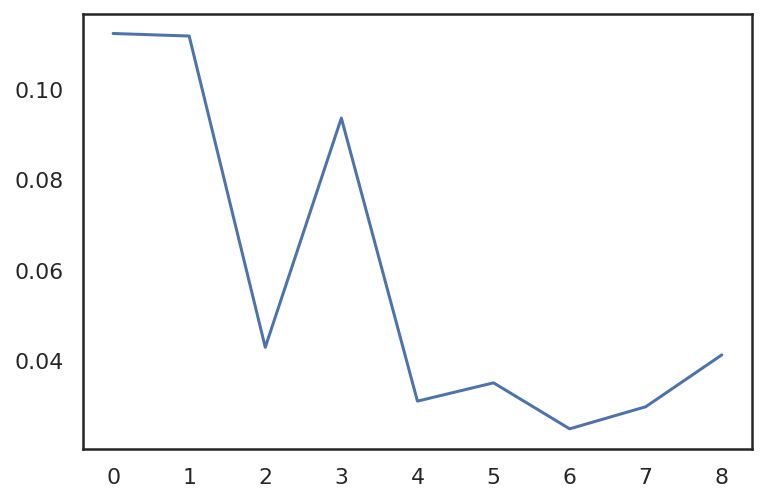

In [0]:
# display(np.unique(model.labels_))
# (model.labels_==0).sum()

plt.plot(scores) # log change 7

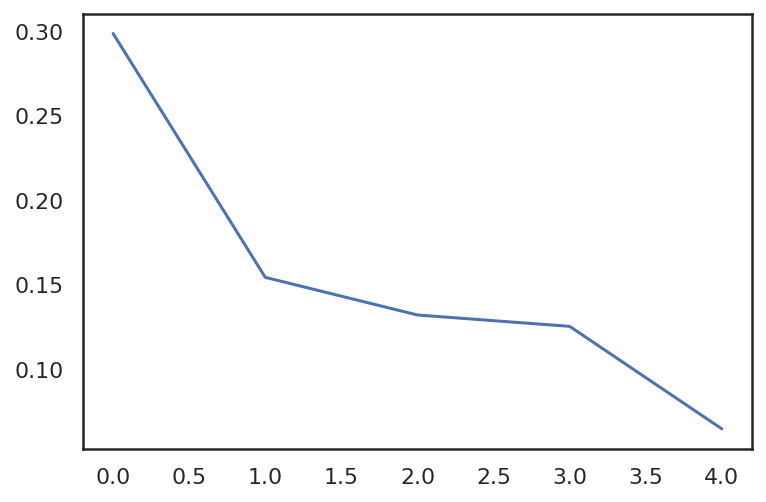

In [0]:
plt.plot(scores) # log change 364kneighbors_graph

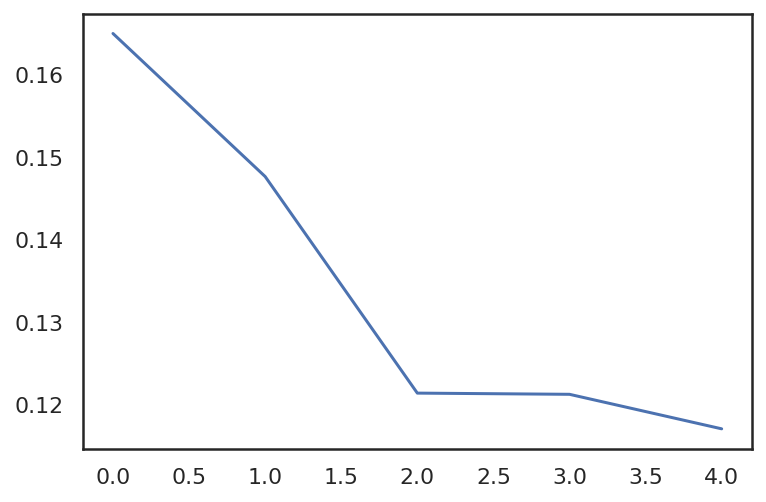

In [0]:
plt.plot(scores) # log change 14

0.07498638

In [0]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,...,d_1664,d_1665,d_1666,d_1667,d_1668,d_1669,d_1670,d_1671,d_1672,d_1673,d_1674,d_1675,d_1676,d_1677,d_1678,d_1679,d_1680,d_1681,d_1682,d_1683,d_1684,d_1685,d_1686,d_1687,d_1688,d_1689,d_1690,d_1691,d_1692,d_1693,d_1694,d_1695,d_1696,d_1697,d_1698,d_1699,d_1700,d_1701,d_1702,d_1703,d_1704,d_1705,d_1706,d_1707,d_1708,d_1709,d_1710,d_1711,d_1712,d_1713,d_1714,d_1715,d_1716,d_1717,d_1718,d_1719,d_1720,d_1721,d_1722,d_1723,d_1724,d_1725,d_1726,d_1727,d_1728,d_1729,d_1730,d_1731,d_1732,d_1733,d_1734,d_1735,d_1736,d_1737,d_1738,d_1739,d_1740,d_1741,d_1742,d_1743,d_1744,d_1745,d_1746,d_1747,d_1748,d_1749,d_1750,d_1751,d_1752,d_1753,d_1754,d_1755,d_1756,d_1757,d_1758,d_1759,d_1760,d_1761,d_1762,d_1763,d_1764,d_1765,d_1766,d_1767,d_1768,d_1769,d_1770,d_1771,d_1772,d_1773,d_1774,d_1775,d_1776,d_1777,d_1778,d_1779,d_1780,d_1781,d_1782,d_1783,d_1784,d_1785,d_1786,d_1787,d_1788,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798,d_1799,d_1800,d_1801,d_1802,d_1803,d_1804,d_1805,d_1806,d_1807,d_1808,d_1809,d_1810,d_1811,d_1812,d_1813,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [0]:
# df_class.diff(7, axis=1)
# df_class.diff(28, axis=1)
# df_class.diff(364, axis=1)

# np.log1p(df_class.astype('float32')+1).pct_change(7, axis=1) 2
# np.log1p(df_class.astype('float32')+1).pct_change(28, axis=1)
# np.log1p(df_class.astype('float32')+1).pct_change(364, axis=1)

# df_class.ewm(7, axis=1).std()
# df_class.ewm(28, axis=1).std()
# df_class.ewm(364, axis=1).std()

# df_class.rolling(7, axis=1).std()
# df_class.rolling(28, axis=1).std()
# df_class.rolling(364, axis=1).std()

# df_class.loc[:, 0::7].apply(lambda x: x.autocorr(7), axis=1)

,d_1184,d_1185,d_1186,d_1187,d_1188,d_1189,d_1190,d_1191,d_1192,d_1193,d_1194,d_1195,d_1196,d_1197,d_1198,d_1199,d_1200,d_1201,d_1202,d_1203,d_1204,d_1205,d_1206,d_1207,d_1208,d_1209,d_1210,d_1211,d_1212,d_1213,d_1214,d_1215,d_1216,d_1217,d_1218,d_1219,d_1220,d_1221,d_1222,d_1223,d_1224,d_1225,d_1226,d_1227,d_1228,d_1229,d_1230,d_1231,d_1232,d_1233,d_1234,d_1235,d_1236,d_1237,d_1238,d_1239,d_1240,d_1241,d_1242,d_1243,d_1244,d_1245,d_1246,d_1247,d_1248,d_1249,d_1250,d_1251,d_1252,d_1253,d_1254,d_1255,d_1256,d_1257,d_1258,d_1259,d_1260,d_1261,d_1262,d_1263,d_1264,d_1265,d_1266,d_1267,d_1268,d_1269,d_1270,d_1271,d_1272,d_1273,d_1274,d_1275,d_1276,d_1277,d_1278,d_1279,d_1280,d_1281,d_1282,d_1283,d_1284,d_1285,d_1286,d_1287,d_1288,d_1289,d_1290,d_1291,d_1292,d_1293,d_1294,d_1295,d_1296,d_1297,d_1298,d_1299,d_1300,d_1301,d_1302,d_1303,d_1304,d_1305,d_1306,d_1307,d_1308,d_1309,d_1310,d_1311,d_1312,d_1313,d_1314,d_1315,d_1316,d_1317,d_1318,d_1319,d_1320,d_1321,d_1322,d_1323,d_1324,d_1325,d_1326,d_1327,d_1328,d_1329,d_1330,d_1331,d_1332,d_1333,d_1334,d_1335,d_1336,d_1337,d_1338,d_1339,d_1340,d_1341,d_1342,d_1343,d_1344,d_1345,d_1346,d_1347,d_1348,d_1349,d_1350,d_1351,d_1352,d_1353,d_1354,d_1355,d_1356,d_1357,d_1358,d_1359,d_1360,d_1361,d_1362,d_1363,d_1364,d_1365,d_1366,d_1367,d_1368,d_1369,d_1370,d_1371,d_1372,d_1373,d_1374,d_1375,d_1376,d_1377,d_1378,d_1379,d_1380,d_1381,d_1382,d_1383,d_1384,d_1385,d_1386,d_1387,d_1388,d_1389,d_1390,d_1391,d_1392,d_1393,d_1394,d_1395,d_1396,d_1397,d_1398,d_1399,d_1400,d_1401,d_1402,d_1403,d_1404,d_1405,d_1406,d_1407,d_1408,d_1409,d_1410,d_1411,d_1412,d_1413,d_1414,d_1415,d_1416,d_1417,d_1418,d_1419,d_1420,d_1421,d_1422,d_1423,d_1424,d_1425,d_1426,d_1427,d_1428,d_1429,d_1430,d_1431,d_1432,d_1433,...,d_1664,d_1665,d_1666,d_1667,d_1668,d_1669,d_1670,d_1671,d_1672,d_1673,d_1674,d_1675,d_1676,d_1677,d_1678,d_1679,d_1680,d_1681,d_1682,d_1683,d_1684,d_1685,d_1686,d_1687,d_1688,d_1689,d_1690,d_1691,d_1692,d_1693,d_1694,d_1695,d_1696,d_1697,d_1698,d_1699,d_1700,d_1701,d_1702,d_1703,d_1704,d_1705,d_1706,d_1707,d_1708,d_1709,d_1710,d_1711,d_1712,d_1713,d_1714,d_1715,d_1716,d_1717,d_1718,d_1719,d_1720,d_1721,d_1722,d_1723,d_1724,d_1725,d_1726,d_1727,d_1728,d_1729,d_1730,d_1731,d_1732,d_1733,d_1734,d_1735,d_1736,d_1737,d_1738,d_1739,d_1740,d_1741,d_1742,d_1743,d_1744,d_1745,d_1746,d_1747,d_1748,d_1749,d_1750,d_1751,d_1752,d_1753,d_1754,d_1755,d_1756,d_1757,d_1758,d_1759,d_1760,d_1761,d_1762,d_1763,d_1764,d_1765,d_1766,d_1767,d_1768,d_1769,d_1770,d_1771,d_1772,d_1773,d_1774,d_1775,d_1776,d_1777,d_1778,d_1779,d_1780,d_1781,d_1782,d_1783,d_1784,d_1785,d_1786,d_1787,d_1788,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798,d_1799,d_1800,d_1801,d_1802,d_1803,d_1804,d_1805,d_1806,d_1807,d_1808,d_1809,d_1810,d_1811,d_1812,d_1813,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,NaN,0.707107,0.578204,0.578204,0.549333,0.507685,0.466292,0.428086,0.506342,0.478545,0.449820,0.421567,0.394438,0.368719,0.344511,0.451222,0.427515,0.403918,0.380835,0.358512,0.337094,0.441010,0.490538,0.472077,0.740448,0.713501,0.683734,0.672411,0.648411,0.621809,0.593738,0.603471,0.580370,0.587009,0.568280,0.546713,0.523421,0.499205,0.532866,0.512144,0.535448,0.518227,0.534770,0.520745,0.503277,0.524632,0.510252,0.492691,0.517491,0.526023,0.717831,0.708985,0.678444,0.670708,0.655486,0.6

In [0]:
def macd(df, signal_line=9):
    first_line = round(12/9*signal_line)
    second_line = round(26/9*signal_line)
    print(first_line, second_line, signal_line)
    macd_line = df.ewm(first_line, min_periods=first_line, axis=1).mean() -\
                df.ewm(second_line, min_periods=second_line, axis=1).mean()
    signal_line = macd_line.ewm(signal_line, min_periods=signal_line, axis=1).mean()
    display(signal_line.head())nbr
    macd_hist = macd_line - signal_line
    
    return macd_hist

# macd = macd(df_class, 3)

In [0]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,...,d_1664,d_1665,d_1666,d_1667,d_1668,d_1669,d_1670,d_1671,d_1672,d_1673,d_1674,d_1675,d_1676,d_1677,d_1678,d_1679,d_1680,d_1681,d_1682,d_1683,d_1684,d_1685,d_1686,d_1687,d_1688,d_1689,d_1690,d_1691,d_1692,d_1693,d_1694,d_1695,d_1696,d_1697,d_1698,d_1699,d_1700,d_1701,d_1702,d_1703,d_1704,d_1705,d_1706,d_1707,d_1708,d_1709,d_1710,d_1711,d_1712,d_1713,d_1714,d_1715,d_1716,d_1717,d_1718,d_1719,d_1720,d_1721,d_1722,d_1723,d_1724,d_1725,d_1726,d_1727,d_1728,d_1729,d_1730,d_1731,d_1732,d_1733,d_1734,d_1735,d_1736,d_1737,d_1738,d_1739,d_1740,d_1741,d_1742,d_1743,d_1744,d_1745,d_1746,d_1747,d_1748,d_1749,d_1750,d_1751,d_1752,d_1753,d_1754,d_1755,d_1756,d_1757,d_1758,d_1759,d_1760,d_1761,d_1762,d_1763,d_1764,d_1765,d_1766,d_1767,d_1768,d_1769,d_1770,d_1771,d_1772,d_1773,d_1774,d_1775,d_1776,d_1777,d_1778,d_1779,d_1780,d_1781,d_1782,d_1783,d_1784,d_1785,d_1786,d_1787,d_1788,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798,d_1799,d_1800,d_1801,d_1802,d_1803,d_1804,d_1805,d_1806,d_1807,d_1808,d_1809,d_1810,d_1811,d_1812,d_1813,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [0]:
df.item_id.unique()

array(['HOBBIES_1_001', 'HOBBIES_1_002', 'HOBBIES_1_003', ...,
       'FOODS_3_825', 'FOODS_3_826', 'FOODS_3_827'], dtype=object)

In [0]:
itemid = 'HOBBIES_1_001'

ica_test = df[(df.item_id==itemid)]
ica_test

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,...,d_1664,d_1665,d_1666,d_1667,d_1668,d_1669,d_1670,d_1671,d_1672,d_1673,d_1674,d_1675,d_1676,d_1677,d_1678,d_1679,d_1680,d_1681,d_1682,d_1683,d_1684,d_1685,d_1686,d_1687,d_1688,d_1689,d_1690,d_1691,d_1692,d_1693,d_1694,d_1695,d_1696,d_1697,d_1698,d_1699,d_1700,d_1701,d_1702,d_1703,d_1704,d_1705,d_1706,d_1707,d_1708,d_1709,d_1710,d_1711,d_1712,d_1713,d_1714,d_1715,d_1716,d_1717,d_1718,d_1719,d_1720,d_1721,d_1722,d_1723,d_1724,d_1725,d_1726,d_1727,d_1728,d_1729,d_1730,d_1731,d_1732,d_1733,d_1734,d_1735,d_1736,d_1737,d_1738,d_1739,d_1740,d_1741,d_1742,d_1743,d_1744,d_1745,d_1746,d_1747,d_1748,d_1749,d_1750,d_1751,d_1752,d_1753,d_1754,d_1755,d_1756,d_1757,d_1758,d_1759,d_1760,d_1761,d_1762,d_1763,d_1764,d_1765,d_1766,d_1767,d_1768,d_1769,d_1770,d_1771,d_1772,d_1773,d_1774,d_1775,d_1776,d_1777,d_1778,d_1779,d_1780,d_1781,d_1782,d_1783,d_1784,d_1785,d_1786,d_1787,d_1788,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798,d_1799,d_1800,d_1801,d_1802,d_1803,d_1804,d_1805,d_1806,d_1807,d_1808,d_1809,d_1810,d_1811,d_1812,d_1813,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [0]:
# for i in range(9, 50, 3):
#     df_macd = macd(df_class, i)
#     df_macd.iloc[4, -100:].plot()
#     plt.show()

In [0]:
# df_class.iloc[9, -100:].plot()

In [0]:
# df_class.loc[0,:].rolling(16).apply(lambda x: x.autocorr(7), raw=False)

# df_class.transform(lambda x: x.rolling(7).autocorr(), axis=1)
        
#             .shift(1+lag)).astype('float16')
# transform(lambda x: x.autocorr(), raw=False, axis=1)

In [0]:
df.rol_std_t7_l0.hist(bins=10, hue=df.item_id)
# plt.xlim((0, 10))

# Pytorch Init

In [0]:
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# print(gpu_info)
# print(!lscpu)

In [0]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

In [0]:
def emb_init(x):
    x = x.weight.data
    std = 2/(x.size(1)+1)
    torch.nn.init.normal_(x, mean=0, std=std)
    # sc = 2/(x.size(1)+1)
    # x.uniform_(-sc,sc)

In [0]:
class Embedding(nn.Module):
    """Container module with an encoder, a recurrent module, and a decoder."""
    
    def __init__(self, emb_szs, batch_size=64, dropout=0.2):
        super().__init__()
        self.drop = nn.Dropout(dropout)
        self.batch_size = batch_size

        self.embeddings = nn.ModuleList([nn.Embedding(r, c) for r, c in emb_szs])
        for i in self.embeddings: emb_init(i)

        emb_len = sum(i.embedding_dim for i in self.embeddings)

        self.fc1 = nn.Linear(emb_len, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = [emb(x[:, i].long()) for i, emb in enumerate(self.embeddings)]
        x = torch.cat(x, dim=1)
        # x = self.drop(x)

        x = self.fc1(x)
        # x = self.dropout(self.fc1(x))
        x = self.fc2(x)
        # x = self.dropout(self.fc3(x))

        return x

In [0]:
class LSTM_Emb_Model(nn.Module):
    """Container module with an encoder, a recurrent module, and a decoder."""

    def __init__(self, emb_szs, cont_len, nlayers=7, dropout=0.2):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.bn = nn.BatchNorm1d(cont_len)

        self.embeddings = nn.ModuleList([nn.Embedding(r, c) for r, c in emb_szs])
        for i in self.embeddings: emb_init(i)
        emb_len = sum(i.embedding_dim for i in self.embeddings)
        ninp = emb_len + cont_len

        self.rnn1 = nn.LSTM(cont_len, 14, nlayers, dropout=dropout, bidirectional=True)
        # self.fc_cats = nn.Linear(emb_len, 1)
        self.fc1 = nn.Linear(emb_len+28, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x_cont, x_cat):

        x_cat = [emb(x_cat[:, i].long()) for i, emb in enumerate(self.embeddings)]
        x_cat = torch.cat(x_cat, dim=1)
        # x_cat = self.dropout(self.fc_cats(x_cat))

        x_cont = self.bn(x_cont)
        x_cont = x_cont.view(len(x_cont), 1, -1)
        x_cont, hid = self.rnn1(x_cont)
        x_cont = x_cont.sum(1)

        x = self.dropout(torch.cat([x_cont, x_cat], dim=1))
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)

        return x

In [0]:
class RNN_Emb_Model(nn.Module):
    """Container module with an encoder, a recurrent module, and a decoder."""

    def __init__(self, emb_szs, cont_len, n_hid=30, nlayers=7, dropout=0.2):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.bn = nn.BatchNorm1d(cont_len)

        self.embeddings = nn.ModuleList([nn.Embedding(r, c) for r, c in emb_szs])
        for i in self.embeddings: emb_init(i)
        emb_len = sum(i.embedding_dim for i in self.embeddings)
        ninp = emb_len + cont_len

        self.rnn1 = nn.RNN(cont_len, n_hid, nlayers, dropout=dropout, bidirectional=True)
        # self.fc_cats = nn.Linear(emb_len, 1)
        self.fc1 = nn.Linear(emb_len+n_hid*2, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x_cont, x_cat):

        x_cat = [emb(x_cat[:, i].long()) for i, emb in enumerate(self.embeddings)]
        x_cat = torch.cat(x_cat, dim=1)
        # x_cat = self.dropout(self.fc_cats(x_cat))

        x_cont = self.bn(x_cont)
        x_cont = x_cont.view(len(x_cont), 1, -1)
        try:
            x_cont, hid = self.rnn1(x_cont, hid)
        except:
            x_cont, hid = self.rnn1(x_cont)
            
        x_cont = x_cont.squeeze(1)

        x = self.dropout(torch.cat([x_cont, x_cat], dim=1))
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)

        return x

# Checkpoint

# Data Pipeline

In [0]:
cats = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'wday', 'month', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
bools = ['snap_CA', 'snap_TX', 'snap_WI', 'event_name_1_in_1d', 'event_name_1_in_3d', 'event_name_1_in_7d']
nums = list(set(df.columns)-set(cats)-set(bools)-set(['d', 'demand']))

In [0]:
# defining types
# nums = params_df
# cats = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'wday', 'month', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
# bools = ['snap_CA', 'snap_TX', 'snap_WI', 'event_name_1_in_1d', 'event_name_1_in_3d', 'event_name_1_in_7d']

In [0]:
# deriving for train test

# masks for nn eval
test_edge_start = 1886 #1913-28+1
test_edge_end = 1913 #1913
test_mask_start_ind = df[df.d == 'd_'+str(test_edge_start)].index[0]
test_mask_end_ind = df[df.d == 'd_'+str(test_edge_end)].index[-1]

val_edge_start = 1856 #1886-30+1
val_edge_end = 1885 #1913-28+1
val_mask_start_ind = df[df.d == 'd_'+str(val_edge_start)].index[0]
val_mask_end_ind = df[df.d == 'd_'+str(val_edge_end)].index[-1]

# train_edge_start = 195
# train_edge_start = 1095
train_edge_start = 1126
# train_edge_start = 1676
train_edge_end = 1855
train_mask_start_ind = df[df.d == 'd_'+str(train_edge_start)].index[0]
train_mask_end_ind = df[df.d == 'd_'+str(train_edge_end)].index[-1]

In [0]:
# oldtry
# X_test = df.loc[test_mask_start_ind:test_mask_end_ind, nums+cats+bools]
# y_test = df.loc[test_mask_start_ind:test_mask_end_ind, :]['demand']

# display(X_test.shape)
# display(y_test.shape)

# X_val = df.loc[val_mask_start_ind:val_mask_end_ind, nums+cats+bools]
# y_val = df.loc[val_mask_start_ind:val_mask_end_ind, :]['demand']

# display(X_val.shape)
# display(y_val.shape)

# X = df.loc[train_mask_start_ind:train_mask_end_ind, nums+cats+bools]
# y = df.loc[train_mask_start_ind:train_mask_end_ind, :]['demand']

# display(X.shape)
# display(y.shape)

# display(df.shape)
# del df

In [0]:
# oldtry Pipeline obviously
get_cat = FunctionTransformer(lambda df: df.loc[:, cats], validate=False)
get_num = FunctionTransformer(lambda df: df.loc[:, nums], validate=False)
get_bool = FunctionTransformer(lambda df: df.loc[:, bools], validate=False)

pl = Pipeline_IMB([    
    ('union_outer', FeatureUnion(transformer_list=[
#         ('get_nums', Pipeline([
#             ('get_num', get_num),
# #             ('discretizer', KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')),
#         ])),
        ('get_cat', Pipeline([
            ('get_cat', get_cat),
            ('lab_enc', OrdinalEncoder())
            # ('ohe', OneHotEncoder(dtype='uint8', handle_unknown='ignore'))
        ])),
        ('get_bools', Pipeline([
            ('get_num', get_bool),
#             ('discretizer', KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')),
        ])),
    ], n_jobs=1, verbose=True)),
    
#     ('dim_red', SelectKBest(f_regression, 5000)),
#     ('sampling', SMOTE(sampling_strategy='auto', n_jobs=12)),
#     ('decomp', TruncatedSVD(n_components=100)),
#     ('dim_red', SelectKBest(chi2, 10000)),
#     ('imp', SimpleImputer(strategy="median")),
#     ('inter', SparseInteractions(degree=2)),
#     ('inter', PolynomialFeatures(degree=2, order='F')),
    # ('scale', MaxAbsScaler()),
    # ('scale', StandardScaler()),
#     ('sfm', SelectFromModel(xgb.XGBRegressor(max_depth=100, tree_method='approx', n_jobs=16), threshold='0.5*mean')),
#     ('dim_red', SelectKBest(chi2, 50)),
#     ('clf', LinearRegression(n_jobs=-1))
#     ('clf', LogisticRegression(class_weight='balanced', n_jobs=12))
#     ('sfm', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=3), threshold=0.015)),
#     ('clf', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=7))
#     ('sfm', SelectFromModel(xgb.XGBRFRegressor(tree_method='hist', random_state=42, n_jobs=12), threshold=0.015)),
#     ('xgb', MultiOutputRegressor(xgb.XGBRFRegressor(objective='reg:squarederror', max_depth=45, tree_method='hist', n_jobs=12,random_state=42)))
#     ('xgb', xgb.XGBRegressor(max_depth=100, tree_method='approx', n_jobs=7))
#     ('clf', LogisticRegression(class_weight='balanced', n_jobs=12))
#     ('clf', RandomForestClassifier(class_weight='balanced', n_jobs=12))
    # ('svc', NuSVR(degree=3, kernel='poly'))
#     ('nn', MLPRegressor(hidden_layer_sizes=(100, 100, 100, 100)))
#     ('svc', SVC(class_weight='balanced'))
#     ('clf', GradientBoostingRegressor(loss= 'huber', max_depth=10))
#     ('clf', MLPRegressor())
])

# X_torch = pl.fit_transform(X)
# X_val_torch = pl.transform(X_val)
# X_test_torch = pl.transform(X_test)

# X_torch = X
# X_val_torch = X_val
# X_test_torch = X_test

In [0]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 30490
label_name = 'demand'

##### NUMS
X_nums = torch.tensor(df.loc[train_mask_start_ind:train_mask_end_ind, nums].values)
X_nums_val = torch.tensor(df.loc[val_mask_start_ind:val_mask_end_ind, nums].values, requires_grad=False)
X_nums_test = torch.tensor(df.loc[test_mask_start_ind:test_mask_end_ind, nums].values, requires_grad=False)

    
##### CATS & BOOLS
X_cats = torch.tensor(df.loc[train_mask_start_ind:train_mask_end_ind, cats+bools].values)
X_cats_val = torch.tensor(df.loc[val_mask_start_ind:val_mask_end_ind, cats+bools].values, requires_grad=False)
X_cats_test = torch.tensor(df.loc[test_mask_start_ind:test_mask_end_ind, cats+bools].values, requires_grad=False)

##### LABELS
y = torch.tensor(df.loc[train_mask_start_ind:train_mask_end_ind, label_name].values.astype('float32')).view(-1, 1)
y_val = torch.tensor(df.loc[val_mask_start_ind:val_mask_end_ind, label_name].values.astype('float32'), requires_grad=False).view(-1, 1)
y_test = torch.tensor(df.loc[test_mask_start_ind:test_mask_end_ind, label_name].values.astype('float32'), requires_grad=False).view(-1, 1)

##### BATCHLOADERS
trainloader = DataLoader(TensorDataset(X_nums, X_cats, y), batch_size=batch_size)
validloader = DataLoader(TensorDataset(X_nums_val, X_cats_val, y_val), batch_size=batch_size)
testloader = DataLoader(TensorDataset(X_nums_test, X_cats_test, y_test), batch_size=batch_size)

In [0]:
# old try

# from torch.utils.data import DataLoader, TensorDataset

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# batch_size = 30490

# ##### NUMS
# try:
#     X_nums_t = torch.tensor(X[nums].values)
#     X_nums_val_t = torch.tensor(X_val[nums].values, requires_grad=False)
#     X_nums_test_t = torch.tensor(X_test[nums].values, requires_grad=False)
# except:
#     X_nums_t = torch.tensor(X[nums].values.astype('float32'))
#     X_nums_val_t = torch.tensor(X_val[nums].values.astype('float32'), requires_grad=False)
#     X_nums_test_t = torch.tensor(X_test[nums].values.astype('float32'), requires_grad=False)
    
# ##### CATS & BOOLS
# try:
#     X_cats_t = torch.tensor(X[cats+bools].values)
#     X_cats_val_t = torch.tensor(X_val[cats+bools].values, requires_grad=False)
#     X_cats_test_t = torch.tensor(X_test[cats+bools].values, requires_grad=False)
# except:
#     X_cats_t = torch.tensor(X[cats+bools].values.astype('float32'))
#     X_cats_val_t = torch.tensor(X_val[cats+bools].values.astype('float32'), requires_grad=False)
#     X_cats_test_t = torch.tensor(X_test[cats+bools].values.astype('float32'), requires_grad=False)

# y_torch = torch.tensor(y.values.astype('float32')).view(-1, 1)
# y_val_torch = torch.tensor(y_val.values.astype('float32')).view(-1, 1)
# y_test_torch = torch.tensor(y_test.values.astype('float32')).view(-1, 1)

# trainloader = DataLoader(TensorDataset(X_nums_t, X_cats_t, y_torch), batch_size=batch_size)
# validloader = DataLoader(TensorDataset(X_nums_val_t, X_cats_val_t, y_val_torch), batch_size=batch_size)
# testloader = DataLoader(TensorDataset(X_nums_test_t, X_cats_test_t, y_test_torch), batch_size=batch_size)

# Model Training

In [23]:
# device selector
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# simple embedding size function
szs = szs_def(df, df[cats+bools].columns)

#model init
model = RNN_Emb_Model(emb_szs=szs, cont_len=len(nums))

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

model.to(device)
model.train()

RNN_Emb_Model(
  (dropout): Dropout(p=0.2, inplace=False)
  (bn): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (embeddings): ModuleList(
    (0): Embedding(30490, 175)
    (1): Embedding(3049, 55)
    (2): Embedding(7, 3)
    (3): Embedding(3, 2)
    (4): Embedding(10, 3)
    (5): Embedding(3, 2)
    (6): Embedding(7, 3)
    (7): Embedding(12, 3)
    (8): Embedding(31, 6)
    (9): Embedding(5, 2)
    (10): Embedding(4, 2)
    (11): Embedding(3, 2)
    (12): Embedding(2, 1)
    (13): Embedding(2, 1)
    (14): Embedding(2, 1)
    (15): Embedding(2, 1)
    (16): Embedding(2, 1)
    (17): Embedding(2, 1)
  )
  (rnn1): RNN(24, 30, num_layers=7, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=324, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [0]:
%%time
epochs = 2
running_loss = 0
print_every = 15
for epoch in range(epochs):
        for batch_ind, (inputs_cont, inputs_cat, labels) in enumerate(trainloader):

            # Move input and label tensors to the default device/
            inputs_cont, inputs_cat, labels = inputs_cont.to(device), inputs_cat.to(device), labels.to(device)

            optimizer.zero_grad()

            logps = model.forward(inputs_cont.float(), inputs_cat.float())
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            gc.collect()

            if (batch_ind+1) % print_every == 0:
                valid_loss = 0
                accuracy = 0
                model.eval()
                with torch.no_grad():
                    for inputs_cont, inputs_cat, labels in validloader:
                        inputs_cont, inputs_cat, labels = inputs_cont.to(device), inputs_cat.to(device), labels.to(device)

                        logps = model.forward(inputs_cont.float(), inputs_cat.float())
                        batch_loss = criterion(logps, labels)

                        valid_loss += batch_loss.item()

                        # Calculate accuracy
                        # ps = torch.exp(logps)
                        # top_p, top_class = ps.topk(1, dim=1)
                        # equals = top_class == labels.view(*top_class.shape)
                        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

                print(f"Epoch {epoch+1}/{epochs}.. "
                      f"Train loss: {running_loss/print_every:.3f}.. "
                      f"Valid loss: {valid_loss/len(validloader):.3f}.. "
                    #   f"Valid accuracy: {accuracy/len(validloader):.3f}"
                    )
                # gpu_info = !nvidia-smi
                # gpu_info = '\n'.join(gpu_info)
                # print(gpu_info)
                model.train()
                running_loss = 0

Epoch 1/2.. Train loss: 14.772.. Valid loss: 15.199.. 
Epoch 1/2.. Train loss: 12.963.. Valid loss: 14.849.. 
Epoch 1/2.. Train loss: 16.558.. Valid loss: 14.216.. 
Epoch 1/2.. Train loss: 14.674.. Valid loss: 13.543.. 
Epoch 1/2.. Train loss: 14.131.. Valid loss: 12.872.. 
Epoch 1/2.. Train loss: 10.230.. Valid loss: 11.979.. 
Epoch 1/2.. Train loss: 12.223.. Valid loss: 11.163.. 
Epoch 1/2.. Train loss: 11.137.. Valid loss: 10.084.. 
Epoch 1/2.. Train loss: 13.228.. Valid loss: 9.395.. 
Epoch 1/2.. Train loss: 10.892.. Valid loss: 8.747.. 
Epoch 1/2.. Train loss: 11.962.. Valid loss: 8.171.. 
Epoch 1/2.. Train loss: 9.438.. Valid loss: 7.608.. 


In [0]:
torch.save(model, './drive/My Drive/Colab Notebooks/model_RNN90_Emb')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNN_Emb_Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
#results

# RNN hid=30
Epoch 1/5.. Train loss: 2.764.. Valid loss: 1.942.. 
Epoch 1/5.. Train loss: 2.572.. Valid loss: 1.782.. 
Epoch 1/5.. Train loss: 2.842.. Valid loss: 1.937.. 
Epoch 1/5.. Train loss: 2.340.. Valid loss: 1.724.. 
Epoch 1/5.. Train loss: 2.934.. Valid loss: 1.726..

# RNN bidir hid=30
Epoch 1/1.. Train loss: 1.418.. Valid loss: 0.749.. 
Epoch 1/1.. Train loss: 1.487.. Valid loss: 0.735.. 
Epoch 1/1.. Train loss: 1.530.. Valid loss: 0.754.. 
Epoch 1/1.. Train loss: 1.352.. Valid loss: 0.722.. 
Epoch 1/1.. Train loss: 1.618.. Valid loss: 0.687.. 

# RNN bidir hid=30 Exp1(Log1(X))
Epoch 1/1.. Train loss: 1.627.. Valid loss: 0.927.. 
Epoch 1/1.. Train loss: 1.767.. Valid loss: 1.041.. 
Epoch 1/1.. Train loss: 1.779.. Valid loss: 0.882.. 
Epoch 1/1.. Train loss: 1.528.. Valid loss: 0.900.. 
Epoch 1/1.. Train loss: 1.877.. Valid loss: 0.921.. 

# RNN bidir hid=60
Epoch 1/1.. Train loss: 0.942.. Valid loss: 0.331.. 
Epoch 1/1.. Train loss: 1.068.. Valid loss: 0.541.. 
Epoch 1/1.. Train loss: 1.153.. Valid loss: 0.342.. 
Epoch 1/1.. Train loss: 1.049.. Valid loss: 0.612.. 
Epoch 1/1.. Train loss: 1.120.. Valid loss: 0.375..  

# RNN bidir hid=30 Log1(X) Exp1(y)
Epoch 1/2.. Train loss: 2.888.. Valid loss: 1.862.. 
Epoch 1/2.. Train loss: 2.647.. Valid loss: 1.921.. 
Epoch 1/2.. Train loss: 3.305.. Valid loss: 1.624.. 
Epoch 1/2.. Train loss: 2.435.. Valid loss: 1.664.. 
Epoch 1/2.. Train loss: 3.482.. Valid loss: 1.796..

# RNN bidir hid=90
Epoch 1/1.. Train loss: 0.795.. Valid loss: 0.255.. 
Epoch 1/1.. Train loss: 0.992.. Valid loss: 0.407.. 
Epoch 1/1.. Train loss: 0.994.. Valid loss: 0.261.. 
Epoch 1/1.. Train loss: 0.885.. Valid loss: 0.349.. 
Epoch 1/1.. Train loss: 0.917.. Valid loss: 0.391.. 

# Loaded models work

In [0]:
# model = torch.load('./drive/My Drive/Colab Notebooks/model_RNN90_Emb')
model = torch.load(PATH + 'model_RNN30_Emb')RU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

RNN_Emb_Model(
  (dropout): Dropout(p=0.2, inplace=False)
  (bn): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (embeddings): ModuleList(
    (0): Embedding(30490, 175)
    (1): Embedding(3049, 55)
    (2): Embedding(7, 3)
    (3): Embedding(3, 2)
    (4): Embedding(10, 3)
    (5): Embedding(3, 2)
    (6): Embedding(7, 3)
    (7): Embedding(12, 3)
    (8): Embedding(31, 6)
    (9): Embedding(5, 2)
    (10): Embedding(4, 2)
    (11): Embedding(3, 2)
    (12): Embedding(2, 1)
    (13): Embedding(2, 1)
    (14): Embedding(2, 1)
    (15): Embedding(2, 1)
    (16): Embedding(2, 1)
    (17): Embedding(2, 1)
  )
  (rnn1): RNN(24, 30, num_layers=7, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=324, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [0]:
# %%time
# _ = adding_cols_byone(df_)
# calendar, params_calendar = load_calendar(def_path=PATH)
# _ = _.reset_index().merge(calendar, how='left', on='d', copy=False).set_index('index')
# _nums = torch.tensor(_[nums].values, requires_grad=False).to(device)
# _cats = torch.tensor(_[cats+bools].values, requires_grad=False).to(device)
# pred = model.forward(x_nums.float(), x_cats.float()).detach().cpu().numpy().astype('float16')
# sub.iloc[:30490, 1] = pred
# _ = _.iloc[:, :7]
# df_ = pd.concat([df_, _], axis=0, copy=False)

In [0]:
%%time
df_ = df.iloc[:, 0:8].copy() # 7 variables + 1 label
sub = pd.read_csv('sample_submission.csv') # load sub
calendar, params_calendar = load_calendar(def_path=PATH)


for i in enumerate(range(1914, 1941+1)): # enumerating for additional counter for sub
    _ = adding_cols_byone(df_, d=f'd_{i[1]}') # forming additional variables
    _ = _.reset_index().merge(calendar, how='left', on='d', copy=False).set_index('index') #adding calendar data
    _nums = torch.tensor(_[nums].values, requires_grad=False).to(device)
    _cats = torch.tensor(_[cats+bools].values, requires_grad=False).to(device)
    pred = model.forward(_nums.float(), _cats.float()).detach().cpu().numpy().astype('float16')
    sub.iloc[:30490, i[0]+1] = pred # writing in sub
    _ = _.iloc[:, :7] # copy only original labels
    _.loc[:, 'demand'] = pred
    df_ = pd.concat([df_, _], axis=0, copy=False)
    print(i[1])
    gc.collect()

1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
CPU times: user 3h 15min 41s, sys: 55.7 s, total: 3h 16min 36s
Wall time: 3h 16min 32s


In [0]:
sub

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.719238,0.750000,0.780762,0.796875,0.822266,0.801758,0.755371,0.773926,0.809082,...,0.804688,0.824707,0.818848,0.733398,0.770020,0.761230,0.787109,0.792480,0.845215,0.828613
1,HOBBIES_1_002_CA_1_validation,0.297119,0.311035,0.328857,0.348633,0.378174,0.370605,0.360352,0.349365,0.374512,...,0.380859,0.367676,0.396240,0.329834,0.341797,0.334717,0.367920,0.367188,0.376953,0.395996
2,HOBBIES_1_003_CA_1_validation,0.452393,0.476562,0.499268,0.529297,0.556152,0.536133,0.531738,0.532227,0.570312,...,0.564941,0.556152,0.586426,0.504883,0.526855,0.515137,0.552734,0.553223,0.571289,0.585938
3,HOBBIES_1_004_CA_1_validation,1.555664,1.549805,1.622070,1.587891,1.602539,1.531250,1.304688,1.326172,1.372070,...,1.336914,1.385742,1.352539,1.262695,1.293945,1.295898,1.307617,1.319336,1.399414,1.352539
4,HOBBIES_1_005_CA_1_validation,0.892578,0.913574,0.968750,0.959473,0.995117,0.984375,0.939453,0.950684,0.996094,...,0.963379,0.971680,0.978027,0.896973,0.925293,0.915527,0.950684,0.958984,0.997070,0.985840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60976,FOODS_3_824_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60977,FOODS_3_825_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60978,FOODS_3_826_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [0]:
# sub=sub_bu.copy()

In [0]:
sub.to_csv('sub.csv', index=False)

In [0]:
def adding_cols_byone(df, d='d_1914', lags=[0, 30, 180], windows=[7, 14], rind=30490, by_col='id', target_col='demand'):
    
####################### подготовка шаблона

    template = df[df.d=='d_1900'].iloc[:,:7].copy() # делаю шаблон на 30490 строк по последнему дню

    start = df.index[-1]+1 # индекс для шаблона
    stop = start+30490
    template.index = np.arange(start, stop)
    
    template.loc[:, 'd'] = d

######################## доп. переменные
    
    for lag in lags:
        
        if lag != 0: # обрезка хвоста, чтобы лаговое значение было последним
            df_downcut = df.iloc[:-lag*rind, :]
        else:
            df_downcut = df.iloc[:, :]
    

        for window in windows:
            
            df_upcut = df_downcut.iloc[-window*rind:, :] # обрезка начала, чтобы ограничить ненужные вычисления
            grouped = df_upcut.groupby(by=by_col)[target_col]

            #rolling mean
            add_param = grouped\
            .transform(lambda x: x.rolling(window).mean()).astype('float16')
            add_param.dropna(inplace=True)
            add_param.index = template.index
            
            sub_column_name = f'rol_mean_t{window}_l{lag}'
#             template = pd.concat([template, add_param.dropna(axis=0)], axis=1)
            template.loc[:, sub_column_name] = add_param
            gc.collect()
            
            #rolling std
            add_param = grouped\
            .transform(lambda x: x.rolling(window).std()).astype('float16')
            add_param.dropna(inplace=True)
            add_param.index = template.index
            
            sub_column_name = f'rol_std_t{window}_l{lag}'
            template.loc[:, sub_column_name] = add_param
            gc.collect()
            
            #ewm mean    
            add_param = grouped\
            .transform(lambda x: x.ewm(window, min_periods=window).mean()).astype('float16')
            add_param.dropna(inplace=True)
            add_param.index = template.index
            
            sub_column_name = f'ewm_mean_t{window}_l{lag}'
            template.loc[:, sub_column_name] = add_param
            gc.collect()
            
            #ewm std    
            add_param = grouped\
            .transform(lambda x: x.ewm(window, min_periods=window).std()).astype('float16')
            add_param.dropna(inplace=True)
            add_param.index = template.index
            
            sub_column_name = f'ewm_std_t{window}_l{lag}'
            template.loc[:, sub_column_name] = add_param
            gc.collect()
            
    return template

In [0]:
%%time

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

model.to(device)
model.train()

# overtraining

epochs = 1
running_loss = 0
print_every = 15
for epoch in range(epochs):
        for batch_ind, (inputs_cont, inputs_cat, labels) in enumerate(validloader):

            # Move input and label tensors to the default device/
            inputs_cont, inputs_cat, labels = inputs_cont.to(device), inputs_cat.to(device), labels.to(device)

            optimizer.zero_grad()

            logps = model.forward(inputs_cont.float(), inputs_cat.float())
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            gc.collect()
        
        for batch_ind, (inputs_cont, inputs_cat, labels) in enumerate(testloader):

            # Move input and label tensors to the default device/
            inputs_cont, inputs_cat, labels = inputs_cont.to(device), inputs_cat.to(device), labels.to(device)

            optimizer.zero_grad()

            logps = model.forward(inputs_cont.float(), inputs_cat.float())
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            gc.collect()

model.eval()

CPU times: user 11min 31s, sys: 17.7 s, total: 11min 49s
Wall time: 11min 50s


RNN_Emb_Model(
  (dropout): Dropout(p=0.2, inplace=False)
  (bn): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (embeddings): ModuleList(
    (0): Embedding(30490, 175)
    (1): Embedding(3049, 55)
    (2): Embedding(7, 3)
    (3): Embedding(3, 2)
    (4): Embedding(10, 3)
    (5): Embedding(3, 2)
    (6): Embedding(7, 3)
    (7): Embedding(12, 3)
    (8): Embedding(31, 6)
    (9): Embedding(5, 2)
    (10): Embedding(4, 2)
    (11): Embedding(3, 2)
    (12): Embedding(2, 1)
    (13): Embedding(2, 1)
    (14): Embedding(2, 1)
    (15): Embedding(2, 1)
    (16): Embedding(2, 1)
    (17): Embedding(2, 1)
  )
  (rnn1): RNN(24, 30, num_layers=7, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=324, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)